# Lie Factor Quantification

Teng-Jui Lin

- Created: 2023-05-28
- Edited: 2024-05-28

In [1]:
from bar_constants import *
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Control Experiment Bar Graphs

### Control 1

(0.0, 60.0)

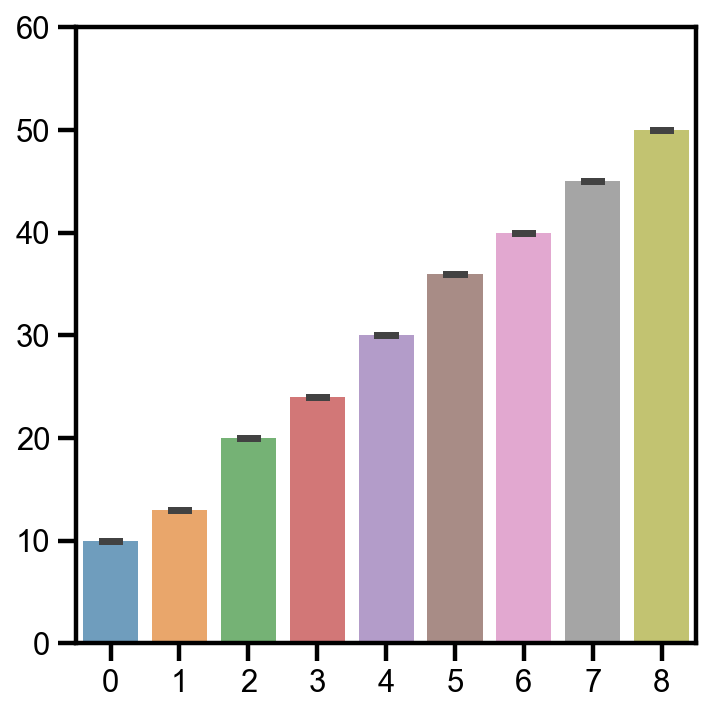

In [2]:
bar_df = pd.DataFrame(np.hstack([
    10 + np.zeros([SAMPLE_SIZE, 1]), 
    13 + np.zeros([SAMPLE_SIZE, 1]), 
    20 + np.zeros([SAMPLE_SIZE, 1]), 
    24 + np.zeros([SAMPLE_SIZE, 1]), 
    30 + np.zeros([SAMPLE_SIZE, 1]), 
    36 + np.zeros([SAMPLE_SIZE, 1]), 
    40 + np.zeros([SAMPLE_SIZE, 1]), 
    45 + np.zeros([SAMPLE_SIZE, 1]), 
    50 + np.zeros([SAMPLE_SIZE, 1]),
]))

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    bar_df,
    errorbar=BAR_ERRORBAR,
    capsize=BAR_CAPSIZE,
    linewidth=BAR_LINEWIDTH,
    edgecolor=BAR_EDGECOLOR,
    alpha=BAR_ALPHA,
    width=BAR_WIDTH,
    ax=ax,
)
# ax.set_box_aspect(2)
ax.set_ylim(0, 60)

In [99]:
def get_size_of_effect(series):
    # get permutations of all items as 2d array
    comb_arr = itertools.permutations(series, 2)
    comb_arr = np.array(list(comb_arr))
    # calculate size of effect for each permutation as series
    effect = np.diff(comb_arr).reshape(-1) / comb_arr[:, 0]
    effect = pd.Series(effect)
    return effect


def _get_lie_factor(viz_series, val_series):
    return get_size_of_effect(viz_series) / get_size_of_effect(val_series)


def get_lie_factor(viz_series, val_series):
    return viz_series / val_series

In [4]:
control1_val_series = pd.Series(np.array([10, 13, 20, 24, 30, 36, 40, 45, 50]))
control1_val_series.name = 'Data Value'
control1_val_series

0    10
1    13
2    20
3    24
4    30
5    36
6    40
7    45
8    50
Name: Data Value, dtype: int64

In [5]:
control1_viz_df = pd.read_csv(os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'control', 'control_fig1.csv'), header=None, index_col=0)
control1_viz_df = control1_viz_df.reset_index(drop=True)
control1_viz_series = control1_viz_df.iloc[:, 0]
control1_viz_series.name = 'Visual Value'
control1_viz_series

0     9.868491
1    12.887194
2    19.898377
3    23.890856
4    29.928263
5    35.868292
6    39.860771
7    44.924403
8    49.890657
Name: Visual Value, dtype: float64

In [6]:
lie_factor_df = _get_lie_factor(control1_viz_series, control1_val_series)

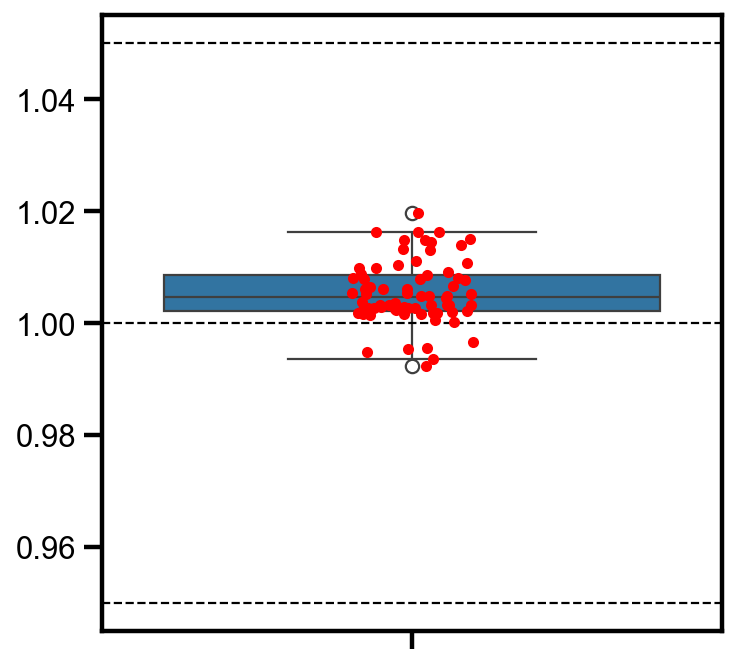

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(
    lie_factor_df,
    ax=ax,
    log_scale=False,
)
sns.stripplot(
    lie_factor_df,
    ax=ax,
    color='r',
)
ax.axhline(1, color='k', ls='--', lw=1)
ax.axhline(1.05, color='k', ls='--', lw=1)
ax.axhline(0.95, color='k', ls='--', lw=1)

### Control 2

(0.0, 140.0)

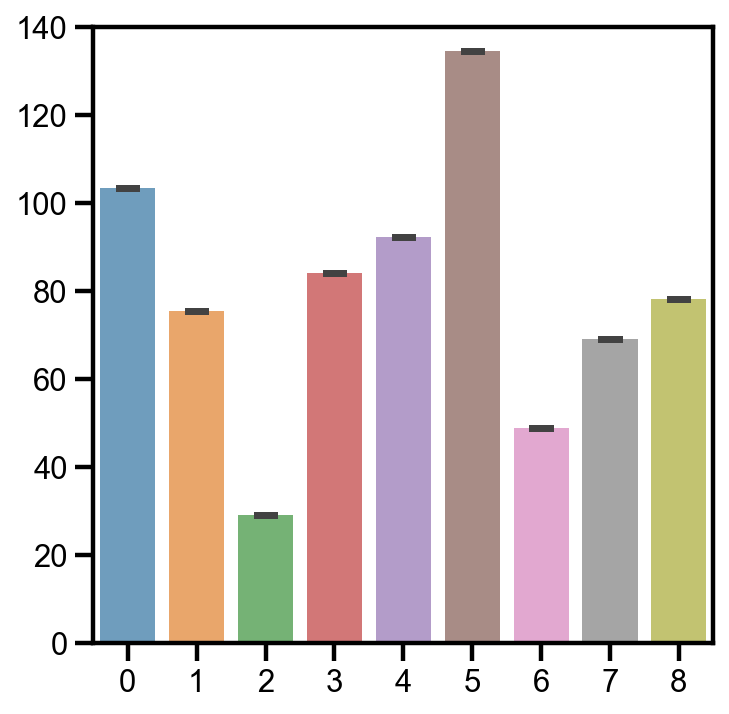

In [8]:
bar_df = pd.DataFrame(np.hstack([
    103.4 + np.zeros([SAMPLE_SIZE, 1]), 
    75.6 + np.zeros([SAMPLE_SIZE, 1]), 
    29.2 + np.zeros([SAMPLE_SIZE, 1]), 
    84.1 + np.zeros([SAMPLE_SIZE, 1]), 
    92.3 + np.zeros([SAMPLE_SIZE, 1]), 
    134.6 + np.zeros([SAMPLE_SIZE, 1]), 
    48.9 + np.zeros([SAMPLE_SIZE, 1]), 
    69.3 + np.zeros([SAMPLE_SIZE, 1]), 
    78.3 + np.zeros([SAMPLE_SIZE, 1]),
]))

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    bar_df,
    errorbar=BAR_ERRORBAR,
    capsize=BAR_CAPSIZE,
    linewidth=BAR_LINEWIDTH,
    edgecolor=BAR_EDGECOLOR,
    alpha=BAR_ALPHA,
    width=BAR_WIDTH,
    ax=ax,
)
# ax.set_box_aspect(2)
ax.set_ylim(0, 140)

In [9]:
control2_val_series = pd.Series(np.array([103.4, 75.6, 29.2, 84.1, 92.3, 134.6, 48.9, 69.3, 78.3]))
control2_val_series.name = 'Data Value'
control2_val_series

0    103.4
1     75.6
2     29.2
3     84.1
4     92.3
5    134.6
6     48.9
7     69.3
8     78.3
Name: Data Value, dtype: float64

In [10]:
control2_viz_df = pd.read_csv(os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'control', 'control_fig2.csv'), header=None, index_col=0)
control2_viz_df = control2_viz_df.reset_index(drop=True)
control2_viz_series = control2_viz_df.iloc[:, 0]
control2_viz_series.name = 'Visual Value'
control2_viz_series

0    103.233107
1     75.285755
2     28.934049
3     83.919896
4     92.099609
5    134.361458
6     48.701688
7     68.923756
8     78.012326
Name: Visual Value, dtype: float64

In [11]:
lie_factor_df = _get_lie_factor(control2_viz_series, control2_val_series)

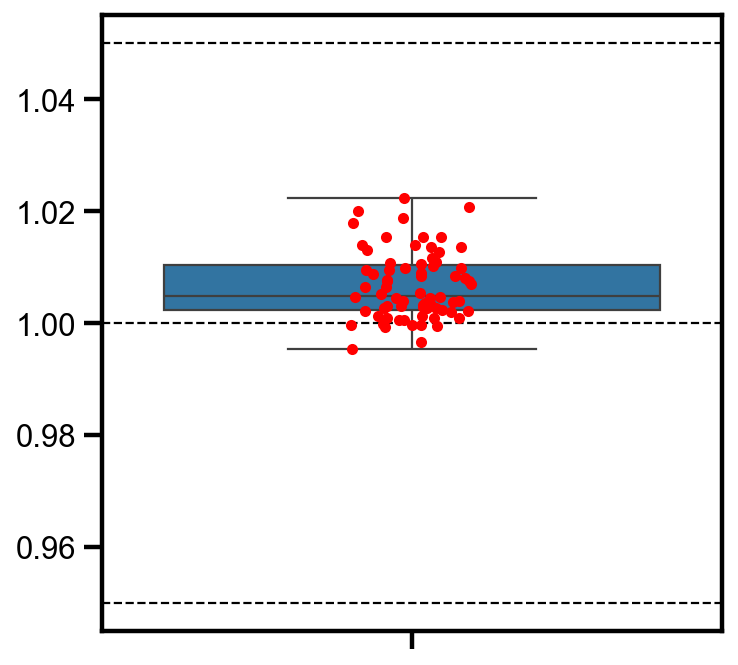

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(
    lie_factor_df,
    ax=ax,
    log_scale=False,
)
sns.stripplot(
    lie_factor_df,
    ax=ax,
    color='r',
)
ax.axhline(1, color='k', ls='--', lw=1)
ax.axhline(1.05, color='k', ls='--', lw=1)
ax.axhline(0.95, color='k', ls='--', lw=1)

## Nature Biomedical Engineering

In [228]:
VIZ_LABEL = 'viz'
VAL_LABEL = 'val'
LOG_SUBDIR = 'log'
ZERO_SUBDIR = 'zero'
OTHERS_SUBDIR = 'others'

In [249]:
filepath = os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'nat_biomed_eng', LOG_SUBDIR)
filenames = os.listdir(filepath)
filenames = pd.Series(filenames)
filenames = filenames[filenames.str.contains(CSV_FILEEXT) & filenames.str.contains(VAL_LABEL)]
filenames = filenames.reset_index(drop=True)
fignames = filenames.str.slice(stop=-8)
filepaths = filepath + os.sep + filenames

In [250]:
raw_df_dict = {}
for i, filepath in enumerate(filepaths):
    val_df = pd.read_csv(filepath, header=None, index_col=0)
    val_df = val_df.reset_index(drop=True)
    val_series = val_df.iloc[:, 0]
    val_series.name = 'Data Value'
    val_effect_series = get_size_of_effect(val_series)
    raw_df_dict[fignames[i]] = val_effect_series

In [251]:
val_series = pd.concat(raw_df_dict)
val_series

10.1038:s41551-023-01143-w_log_fig4  0     -0.104353
                                     1      1.095885
                                     2      0.099071
                                     3     -0.197817
                                     4     -0.702488
                                              ...   
10.1038:s41551-023-01143-w_log_fig1  235   -0.959726
                                     236   -0.615162
                                     237   -0.619905
                                     238   -0.995048
                                     239    0.132035
Length: 2778, dtype: float64

In [252]:
filepath = os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'nat_biomed_eng', LOG_SUBDIR)
filenames = os.listdir(filepath)
filenames = pd.Series(filenames)
filenames = filenames[filenames.str.contains(CSV_FILEEXT) & filenames.str.contains(VIZ_LABEL)]
filenames = filenames.reset_index(drop=True)
fignames = filenames.str.slice(stop=-8)
filepaths = filepath + os.sep + filenames

In [253]:
raw_df_dict = {}
for i, filepath in enumerate(filepaths):
    viz_df = pd.read_csv(filepath, header=None, index_col=0)
    viz_df = viz_df.reset_index(drop=True)
    viz_series = viz_df.iloc[:, 0]
    viz_series.name = 'Data Value'
    viz_effect_series = get_size_of_effect(viz_series)
    raw_df_dict[fignames[i]] = viz_effect_series

In [254]:
viz_series = pd.concat(raw_df_dict)
viz_series

10.1038:s41551-023-01028-y_log_fig1  0    -0.005660
                                     1    -0.896226
                                     2    -0.332075
                                     3    -0.877358
                                     4    -0.505660
                                             ...   
10.1038:s41551-023-01146-7_log_fig2  7     0.829630
                                     8     0.622222
                                     9     0.109589
                                     10    0.127854
                                     11   -0.383562
Length: 2778, dtype: float64

In [257]:
lie_factor_df = get_lie_factor(viz_series, val_series)
lie_factor_df

10.1038:s41551-022-01001-1_log_fig1  0     1.355183
                                     1     1.432247
                                     2     1.274910
                                     3     1.364661
                                     4     1.290088
                                             ...   
10.1038:s41551-023-01146-7_log_fig2  7     0.006492
                                     8     0.016712
                                     9     0.059814
                                     10    0.053975
                                     11    0.393864
Length: 2778, dtype: float64

In [258]:
lie_factor_df.min()

0.000273479913501532

In [259]:
lie_factor_df.max()

5.23615886485869

In [260]:
lie_factor_df.median()

0.2974004326975096

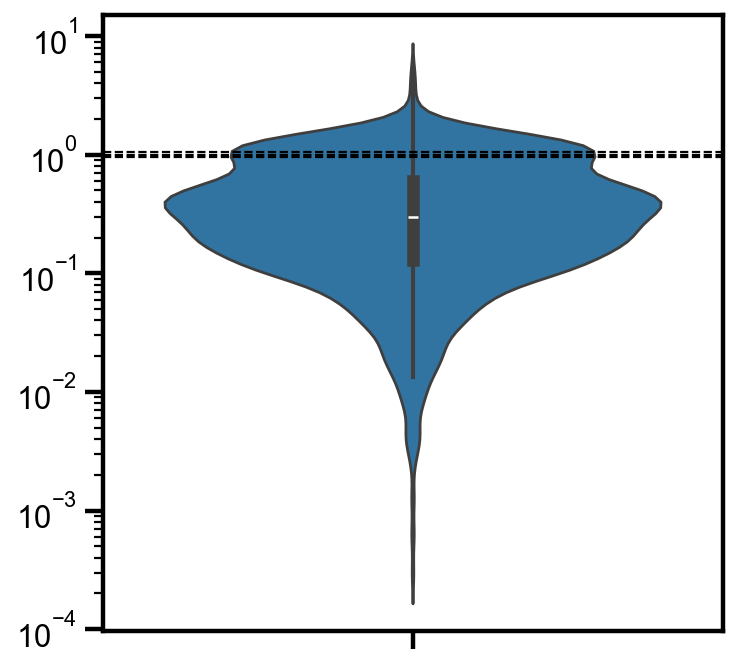

In [261]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_yscale('log')
sns.violinplot(
    lie_factor_df,
    ax=ax,
)
ax.axhline(1, color='k', ls='--', lw=1)
ax.axhline(1.05, color='k', ls='--', lw=1)
ax.axhline(0.95, color='k', ls='--', lw=1)

<Axes: ylabel='Count'>

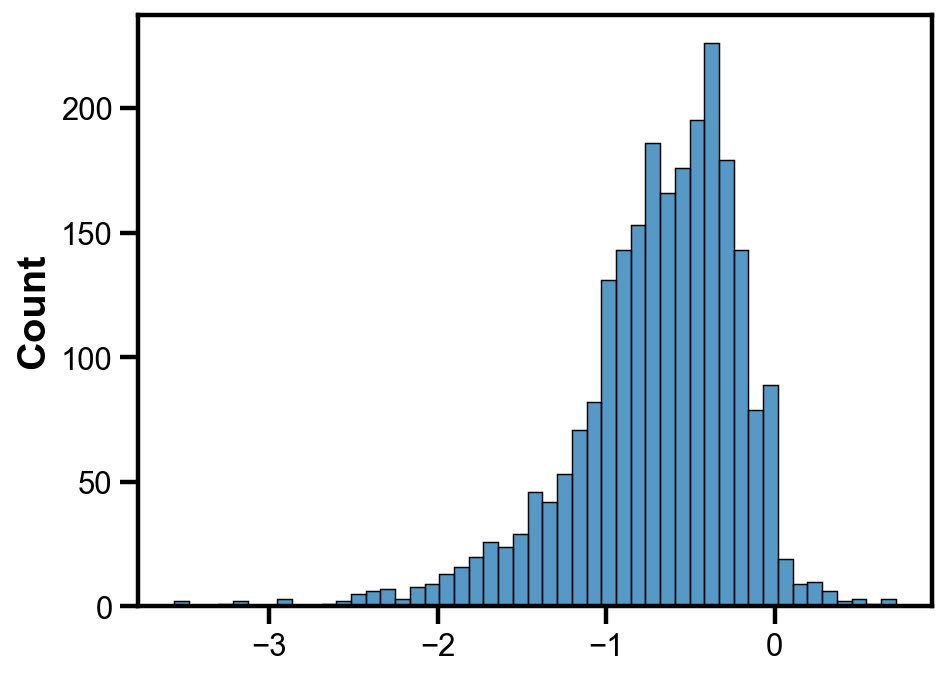

In [238]:
sns.histplot(np.log10(lie_factor_df))